filename: minianalysis__models_run_on_last_year_vs_next_year.py

description: 
    last updated: 6/13/2014
    Run model on last year of data used vs. next available year of data, as long as it is within a provided bound    
    
inputs:

outputs:

@author: Misha


In [2]:
from __future__ import division
# %matplotlib inline

import matplotlib.pyplot as plt

import pandas as pd
#import cPickle as cp

import sys
sys.path.append('../')    
import GSSUtility as GU

import numpy as np
import statsmodels.formula.api as smf 
import random
from scipy.stats import pearsonr, ttest_ind, ttest_rel
import time
from collections import Counter
from collections import defaultdict

import seaborn

/home/misha/python/pandas-0.16.0-py2.7-linux-x86_64.egg/pandas/rpy/__init__.py:8: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2, found here: http://rpy.sourceforge.net
  "like rpy2, found here: http://rpy.sourceforge.net", FutureWarning)


In [3]:
%rm ../GSSUtility.pyc # remove this file because otherwise it will be used instead of the updated .py file
reload(GU)

<module 'GSSUtility' from '../GSSUtility.py'>

In [ ]:
#*********************************************************
allPropsForYearsUsed = []
allPropsForYearsPossible =[]
allParamSizesForYearsUsed = []
allParamSizesForYearsPossible = []
allRsForYearsUsed, allRsForYearsPossible = [], []

 
############################################################
if __name__ == "__main__":    
    
    pathToData = '../../Data/'
    dataCont = GU.dataContainer(pathToData)
    
    articlesToUse = GU.filterArticles(dataCont.articleClasses, GSSYearsUsed=True, GSSYearsPossible=True, \
                                        centralIVs=True, nextYearBound=3) #, linearModels=True)            
    print 'len of articleClasses:', len(articlesToUse)
#     raw_input('...')
    
    # define the storage containers for outputs
    group1 = 'on last GSS year'
    group2 = 'on first "future" GSS year'   
    groups = [group1, group2]
    outcomes = ['propSig', 'paramSizesNormed', 'Rs', 'adjRs', 'pvalues',  'numTotal', \
                'propSig_CentralVars', 'paramSizesNormed_CentralVars', 'pvalues_CentralVars']

    output = defaultdict(dict)
    output['metadata'] = {'article_id':[]}
    for group in groups:
        for outcome in outcomes:
            output[group][outcome] = []
    
#     log=open('log_file.txt', 'w')       
#     for article in random.sample(articlesToUse, 200):
    for article in articlesToUse:
    #for article in [a for a in articlesToUse if a.articleID == 6755]:
    
        print '\n===================\nProcessing article:', article.articleID
        
        RHS = article.IVs + article.controls
        
        for DV in article.DVs:
#             print DV, '~', RHS
            maxYearUsed = max(article.GSSYearsUsed)
            futureYearsPossible = [yr for yr in article.GSSYearsPossible if yr > maxYearUsed]
            nextYear = min(futureYearsPossible) # the arguments of GU.filterArticles function ensure that there is a suitable future year (within bound)
            
#             log.write('id'+str(article.articleID)+' year '+str(maxYearUsed))
            
            resOnDataUsed = GU.runModel(dataCont, maxYearUsed, DV, RHS) # models run on max year of data used
            if not resOnDataUsed: continue
            
#             log.write('id'+str(article.articleID)+' year '+str(nextYear))           
            resOnNextYear = GU.runModel(dataCont, nextYear, DV, RHS) # models run on min year of future data
            if not resOnNextYear: continue
            
            # Checks on which results to record                
            if len(resOnDataUsed.params) != len(resOnNextYear.params):
                print 'The number of variables in original model is different from the number in model on future years. Skipping.'                    
                continue
            
            # the condition below means that i don't care about models in which orig var isn't stat. sig.
#            if results.pvalues[-1] > 0.05: continue
            results = [resOnDataUsed, resOnNextYear]
 
            centralVars = []            
            for civ in article.centralIVs:
                if 'standardize(%s, ddof=1)' % (civ) in results[0].params.index:
                    centralVars.append('standardize(%s, ddof=1)' % (civ))
                else: 
                    for col in results[0].params.index:
                        if 'C(' + civ + ')' in col:
                            centralVars.append(col)
 
#             print 'IVs:', article.IVs
#             print 'centralVas:', centralVars
#            raw_input('...')
            '''                
            centralVars = ['standardize(%s, ddof=1)' % (cv) for cv in article.centralIVs]
            centralVars = set(centralVars).intersection(results[0].params.index) # need this step because some central                                                                                            # var columns may be removed when running model
            '''

            # The reasoning for the condition below is that authors make two types of arguments for "central" variables, 
            # (1) that the central variable is really important, p < 0.05, or (2) that the central variable is not important (p > 0.05). 
            # What we want to test by replacing the variable with a cognate are arguments of type (1). 
            # Arguments of type (2) are important and testable too, but if we test all of these together, we will obscure both effects.
            # So the condition below ensures that at least one of the central variables was found to be "important" in the original 
            # article.
            # This throws away 67 observations.
#             if np.all(results[0].pvalues[centralVars] > 0.05): 
#                 print 'All "central" IVs are p > 0.05. Skipping.'
#                 continue
                
            for i in range(2):                 
                output[groups[i]]['Rs'].append(results[i].rsquared) 
                output[groups[i]]['adjRs'].append(results[i].rsquared_adj) 
                output[groups[i]]['propSig'].append(float(len([p for p in results[i].pvalues[1:] if p < 0.05]))/len(results[i].params[1:])) 
                output[groups[i]]['paramSizesNormed'].append(np.mean(results[i].params[1:].abs())) 
                output[groups[i]]['pvalues'].append(np.mean( results[i].pvalues[1:]))
                output[groups[i]]['numTotal'].append( 1 ) #divide by len of R^2 array to get a mean of variables estimated PER model                           
                
                if len(centralVars)>0:
                    output[groups[i]]['pvalues_CentralVars'].append(np.mean(results[i].pvalues[centralVars]))               
                    output[groups[i]]['propSig_CentralVars'].append(float(len([p for p in results[i].pvalues[centralVars] if p < 0.05])) \
                                                            /len(results[i].params[centralVars])) 
                    output[groups[i]]['paramSizesNormed_CentralVars'].append(np.mean(results[i].params[centralVars].abs()))                
                else:
                    output[groups[i]]['pvalues_CentralVars'].append(np.nan)
                    output[groups[i]]['propSig_CentralVars'].append(np.nan)
                    output[groups[i]]['paramSizesNormed_CentralVars'].append(np.nan)
                    
            output['metadata']['article_id'].append(article.articleID)                 
     
   
    
#     print 'TTests'
#     for outcome in outcomes:
#         print 'Means of group1 and group2:', np.mean(output[group1][outcome]), np.mean(output[group2][outcome]), 'Paired T-test of ' + outcome, ttest_rel(output[group1][outcome], output[group2][outcome])


len of articleClasses: 435

Processing article: 6910
full rank but no imputation
not full rank no imputation or another problem
imputed just fine
full rank but no imputation
not full rank no imputation or another problem
imputed just fine
The number of variables in original model is different from the number in model on future years. Skipping.
full rank but no imputation
not full rank no imputation or another problem
imputed just fine
full rank but no imputation
not full rank no imputation or another problem
imputed just fine
The number of variables in original model is different from the number in model on future years. Skipping.
full rank but no imputation
not full rank no imputation or another problem
imputed just fine
full rank but no imputation
not full rank no imputation or another problem
imputed just fine
The number of variables in original model is different from the number in model on future years. Skipping.
full rank but no imputation
not full rank no imputation or another p

Create dataframe that contains the output 
--

In [4]:
df_output = pd.DataFrame(index=np.arange(len(output[group1]['propSig'])), columns=pd.MultiIndex.from_product([groups, outcomes]))
df_output.columns.names = ['outcome','group']
for outcome in outcomes:
    for gp in groups:
        df_output[gp, outcome] = output[gp][outcome]
df_output['article_id'] = output['metadata']['article_id']
del df_output[group1, 'numTotal']
del df_output[group2, 'numTotal']

df_output.to_pickle('df_output.pickle')
# df_output

In [22]:
# if using another, non-ipython notebook method of running the code
# load in the output of that other method, and set up the relevant variables
df_output = pd.read_pickle('df_output.pickle')
group1 = 'on last GSS year'
group2 = 'on first "future" GSS year'   
groups = [group1, group2]
outcomes = ['propSig', 'paramSizesNormed', 'Rs', 'adjRs', 'pvalues',  'numTotal', \
            'propSig_CentralVars', 'paramSizesNormed_CentralVars', 'pvalues_CentralVars']
df_output.head()

outcome on last GSS year                                                 \
group            propSig paramSizesNormed        Rs     adjRs   pvalues   
0                   0.00         0.241433  0.011548 -0.001553  0.552687   
1                   0.10         0.458258  0.041716  0.029016  0.299841   
2                   0.15         0.394174  0.099016  0.087074  0.349310   
3                   0.10         0.137044  0.018829  0.005825  0.486948   
4                   0.05         0.306807  0.063843  0.051435  0.512004   

outcome                                                                       \
group   propSig_CentralVars paramSizesNormed_CentralVars pvalues_CentralVars   
0                      0.00                     0.241433            0.552687   
1                      0.10                     0.458258            0.299841   
2                      0.15                     0.394174            0.349310   
3                      0.10                     0.137044            0.486948   
4                      0.05                     0.306807            0.512004   

outcome on first "future" GSS year                                       \
group                      propSig paramSizesNormed        Rs     adjRs   
0                             0.10         0.150609  0.017216  0.003633   
1                             0.10         0.319540  0.053854  0.040777   
2                             0.15         0.229463  0.132881  0.120896   
3                             0.10         0.086102  0.016995  0.003408   
4                             0.25         0.128490  0.134176  0.122209   

outcome                                                             \
group     pvalues propSig_CentralVars paramSizesNormed_CentralVars   
0        0.493678                0.10                     0.138580   
1        0.309483                0.10                     0.292225   
2        0.401350                0.15                     0.208116   
3        0.525636                0.10                     0.086395   
4        0.487359                0.25                     0.127416   

outcome                     article_id  
group   pvalues_CentralVars             
0                  0.488463          9  
1                  0.313768          9  
2                  0.404564          9  
3                  0.505430          9  
4                  0.469697          9

In [23]:
outcomes.remove('numTotal')

###Number of unique articles used

In [24]:
print 'Number of unique articles used:', len(df_output['article_id'].unique())

Number of unique articles used: 305


Plot the output
--

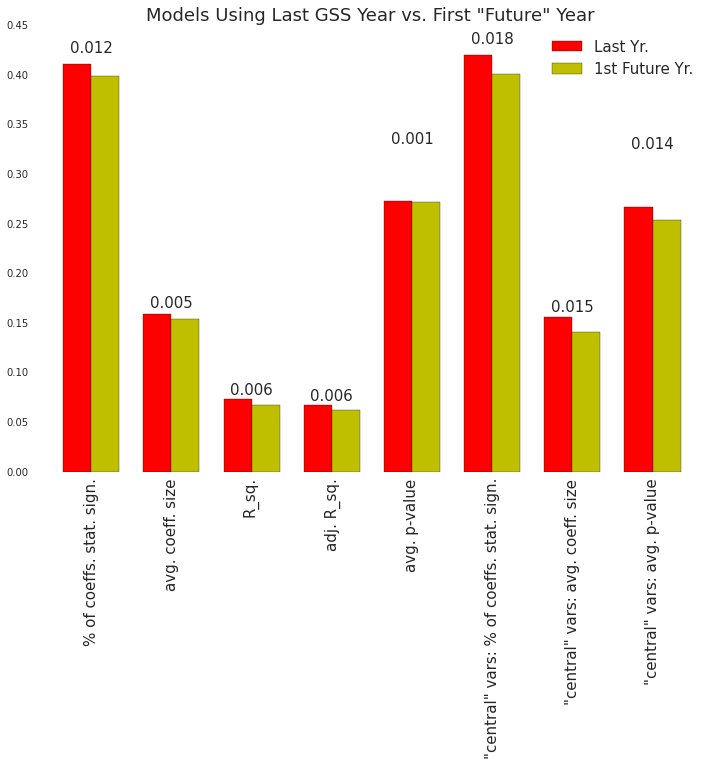

In [25]:
%matplotlib inline
outcomesToUse = df_output[group1].columns
indices = np.arange(len(outcomesToUse))
width = 0.35
axes = plt.figure(figsize=(12,8)).add_subplot(111)
rects1 = plt.bar(left=indices, width=width, height=df_output[group1].mean(), color='r')#, yerr=df_output['orig. models'].std()) #this is not relevant because we're not comparing groups
rects2 = plt.bar(left=indices+width, width=width, height=df_output[group2].mean(), color='y')#, yerr=df_output['cognate models'].std())

# title, legend, etc
plt.title('Models Using Last GSS Year vs. First "Future" Year', fontsize=18)
plt.legend((rects1[0], rects2[0]), ('Last Yr.', '1st Future Yr.'), fontsize=15)
plt.xlim((-1*width, len(outcomesToUse)))

# tick labels
# a = outcomesToUse
a = ['% of coeffs. stat. sign.', 'avg. coeff. size', 'R_sq.', 'adj. R_sq.', 'avg. p-value', \
     '"central" vars: % of coeffs. stat. sign.', '"central" vars: avg. coeff. size', '"central" vars: avg. p-value']
axes.set_xticks(indices+width)
axes.set_xticklabels(a, rotation=90, fontsize=15)

# label the bars with the difference between them
diffs = (df_output[group1] - df_output[group2]).mean().values
def autolabel(rects):
    # attach some text labels
    for i, rect in enumerate(rects):
        height = rect.get_height()
        if i!=7 and i!=4:
            axes.text(rect.get_x()+width, 1.02*height, '%0.3f'%diffs[i],
                    ha='center', va='bottom', fontsize=15)
        else: # this is for the p-value label, which has gone up
            axes.text(rect.get_x()+width, 1.02*height+0.05, '%0.3f'%diffs[i],
                    ha='center', va='bottom', fontsize=15)
autolabel(rects1)

# savefig('../../Images/ASA2015/models_using_last_gss_year_vs_first_future_year.png', bbox_inches='tight')

Perform t-tests
--

In [ ]:
# import rpy2.robjects as robjects
# import pandas.rpy.common as com
# from rpy2.robjects import pandas2ri
# pandas2ri.activate()
# r = robjects.r

# article = articlesToUse[10]
# mydf = dataCont.df.loc[1974, article.DVs+article.IVs]
# mydf.head()

In [16]:
# # (df_output['adjRs','orig. models'] - df_output['adjRs','cognate models']).plot(kind='kde')

# from scipy.stats import ttest_1samp
# for outcome in outcomes:
#     print outcome
#     print 'mean group 1', df_output[group1, outcome].mean()
#     print 'mean group 2', df_output[group2, outcome].mean()
#     print ttest_rel(df_output[group1, outcome], df_output[group2, outcome])[1]
#     print

Perform t-tests and Tests using *clustered errors*
--

1. Perform related-sample t-test (samples must be of equal lengths)

2. Perform independent samples t-test (just for kicks, to see how big our effects are)

3. Perform clustered error tests. To do this I will do a hack by running a regression with clustered errors and using that as the t-test. Source/inspiration is: http://www.stata.com/statalist/archive/2010-05/msg00663.html

Note: I am not using the 'df_correction' flag in get_robustcov_results() because that's apparently something HLM does, not canonical clustered errors:
"This method of correcting the standard errors to account for the intraclass correlation is a "weaker" form of correction than using a multilevel model, which not only accounts for the intraclass correlation, but also corrects the denominator degrees of freedom for the number of clusters."
source: http://www.ats.ucla.edu/stat/stata/library/cpsu.htm

Note
--
For some reason, I'm getting different clustered-errors-p-values when I use the 'cluster' flag in the 
fit() function vs. when I calculate the result normally and then use get_robustcov_results function on that result. The former method yields slightly smaller p-values.

Outcome
--
The p-values are larger (for some outcomes, they are now > 0.05) but are still sufficiently small?


In [17]:
# (df_output['adjRs','orig. models'] - df_output['adjRs','cognate models']).plot(kind='kde')

from scipy.stats import ttest_rel
import statsmodels.formula.api as smf

for outcome in outcomes:
    print outcome
    print 'Mean before substitution:', np.around(df_output[group1, outcome].mean(), 3)
    print 'Mean after substitution:', np.around(df_output[group2, outcome].mean(), 3)
    print 'Related samples t-test p-value:', np.around(ttest_rel(df_output[group1, outcome], df_output[group2, outcome])[1], 6)
 
    # GET CLUSTERED ERRORS
    # to do this run a regression Y ~ X where Y = outcomes, X = dummy {0=group1, 1=group2}
    # 1. Define variables
    outcomes_combined = list(df_output[group1, outcome]) + list(df_output[group2, outcome])
    diffs = df_output[group1, outcome] - df_output[group2, outcome]
    dummy = [0]*len(df_output[group1, outcome]) + [1]*len(df_output[group2, outcome])
    
    # 2. Fit models
#     result = smf.ols(formula='y~x', data=pd.DataFrame({'y':outcomes_combined, 'x':dummy})).fit() # do I need a constant???
#     result = smf.ols(formula='y~x-1', data=pd.DataFrame({'y':diffs, 'x':[1]*len(diffs)})).fit()
    result_clustered = smf.ols(formula='y~x-1', \
                     data=pd.DataFrame({'y':diffs, 'x':[1]*len(diffs)})).fit(missing='drop', \
                                                                             cov_type='cluster', \
                                                            cov_kwds=dict(groups=df_output.article_id))
                                                                                               
# these two methods produce slightly different results. neither is necessary because i'm using parameters
# of the model.fit() method above instead to use clustered standard errors.
#     # 3. Get clustered standard errors
#     robust_results = result.get_robustcov_results(cov_type='cluster', 
#                                                   use_correction=True,
#                                                   groups=article_ids, # this is article_id doubled
#                                                   df_correction=True) 
    
#     # 3.1 Get clustered standard errors another way, by regression diffs ~ const and seeing if const!=0
#     result_rob = result.get_robustcov_results(cov_type='cluster', \
#                                            groups=article_ids) # this is article_id singled
    
    print 'Clustered errors p-value:', np.around(result_clustered.pvalues[0], 3)    
#     print 'clustered errors p-value:', np.around(result_rob.pvalues[0], 3)
    print

propSig
Mean before substitution: 0.475
Mean after substitution: 0.477
Related samples t-test p-value: 0.731899
Clustered errors p-value: 0.803

paramSizesNormed
Mean before substitution: 0.167
Mean after substitution: 0.162
Related samples t-test p-value: 0.001963
Clustered errors p-value: 0.058

Rs
Mean before substitution: 0.094
Mean after substitution: 0.091
Related samples t-test p-value: 9.6e-05
Clustered errors p-value: 0.003

adjRs
Mean before substitution: 0.088
Mean after substitution: 0.085
Related samples t-test p-value: 0.000476
Clustered errors p-value: 0.007

pvalues
Mean before substitution: 0.23
Mean after substitution: 0.232
Related samples t-test p-value: 0.69056
Clustered errors p-value: 0.768

propSig_CentralVars
Mean before substitution: 0.479
Mean after substitution: 0.483
Related samples t-test p-value: nan


ValueError: The weights and list don't have the same length.

How many models' avg p-value is above 0.05?
--

In [ ]:
# # need to see tally up how switched from being below to being above
# # i.e. need to condition on being below beforehand, and how many of those are above now

# print 'count:', df_output[group2]['pvalues'][df_output[group2]['pvalues'] > 0.05].shape[0]
# print 'total:', df_output.shape[0]
# print 'percent:', df_output[]['pvalues'][df_output['cognate models']['pvalues'] > 0.05].shape[0]/ df_output.shape[0]